In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
#import mpld3
#mpld3.enable_notebook()

from scipy import optimize
import lmfit as lmf

import sys
sys.path.append('../python/')
from EdwRes import *
from prob_dist import *

In [19]:
# import data from Edelweiss
res_data = pd.read_csv("data/edelweiss_NRwidth_GGA3_data.txt", skiprows=1, \
                       names=['E_recoil', 'sig_NR', 'E_recoil_err', 'sig_NR_err'], \
                       delim_whitespace=True)

resER_data = pd.read_csv("data/edelweiss_ERwidth_GGA3_data.txt", skiprows=1, \
                         names=['E_recoil', 'sig_ER', 'sig_ER_err'], \
                         delim_whitespace=True)

resER_data = resER_data.sort_values(by='E_recoil')

print (res_data.head(10))
E_recoil = res_data["E_recoil"]
sig_NR = res_data["sig_NR"]
sig_NR_err = res_data['sig_NR_err']

   E_recoil    sig_NR  E_recoil_err  sig_NR_err
0   16.1946  0.062345      0.946176    0.001157
1   16.4428  0.062345      0.945278    0.001157
2   44.2627  0.046528      0.992477    0.001543
3   24.5012  0.059397      0.992477    0.001185
4   97.7172  0.044847      1.033260    0.002783
5   58.4014  0.050082      0.991830    0.002288
6   34.2156  0.053417      1.033260    0.001102


In [20]:
# GGA3 parameters from Edelweiss tables
ion_center_0keV = 1.3
ion_guard_0keV = 1.5
heat_0keV = 0.4
ion_122keV = 3.1 #3.3 #3.1
heat_122keV = 2.7
#aH = 0.0157
pars = {
    'V' : 4.0,
    'eps_eV' : 3.0
    }

In [23]:
# lmfit needs a residuals function
# par_dict is a dictionary of the form
# {'V': 4.0, 'eps_eV': 3.0}
def residualNR(params, x, data, eps_data, par_dict):
    ion_center_0keV = params['ion_center_0keV']
    ion_guard_0keV = params['ion_guard_0keV']
    ion_122keV = params['ion_122keV']
    heat_0keV = params['heat_0keV']
    heat_122keV = params['heat_122keV']
    aH = params['aH']
    C = params['C']
    m = params['m']

    fit_func = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, par_dict, aH, C, m)
    
    model = fit_func(x)

    return (data-model) / eps_data

def residualER(params, x, data, eps_data, par_dict):
    ion_center_0keV = params['ion_center_0keV']
    ion_guard_0keV = params['ion_guard_0keV']
    ion_122keV = params['ion_122keV']
    heat_0keV = params['heat_0keV']
    heat_122keV = params['heat_122keV']
    aH = params['aH']

    #fit_func = get_sig_gamma_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, par_dict, aH)
    #model = fit_func(x)
    
    #sigmomEdw(Er,band='ER',label='GGA3',F=0.000001,V=4.0,aH=0.035,alpha=(1/100))
    model = sigmomEdw(x,band='ER',label='GGA3',F=0.000001,V=4.0,aH=aH,alpha=(1/10000))
    
    return (data-model) / eps_data

In [24]:
# Edelweiss fits aH first
paramsER = lmf.Parameters()
paramsER.add('ion_center_0keV', value=ion_center_0keV, vary=False)
paramsER.add('ion_guard_0keV', value=ion_guard_0keV, vary=False)
paramsER.add('ion_122keV', value=ion_122keV, vary=False)
paramsER.add('heat_0keV', value=heat_0keV, vary=False)
paramsER.add('heat_122keV', value=heat_122keV, vary=False)
#paramsER.add('pars', value=pars, vary=False)
paramsER.add('aH', value=0.01638)

mask = [True, True, False, False, True, True, True, True, True]
lmfoutER = lmf.minimize(residualER, paramsER, \
                        args=(resER_data["E_recoil"][mask], resER_data["sig_ER"][mask], resER_data["sig_ER_err"][mask], pars))

print('lmfit result--ER')
print(lmf.report_fit(lmfoutER.params))
# note that FWHM_to_SIG is from EdwRes library
print('aH_FWHM is ', lmfoutER.params['aH']/FWHM_to_SIG)

sig_er_func = get_sig_gamma_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, pars, aH=lmfoutER.params['aH'])
E_recoil_arr = np.linspace(10, 200, 100)
plt.plot(E_recoil_arr, sig_er_func(E_recoil_arr))


plt.plot(resER_data["E_recoil"][mask], resER_data["sig_ER"][mask],'.')
plt.ylabel('ER width (1-sigma)')
plt.xlabel('Recoil Energy (keV)')

TypeError: cannot convert the series to <class 'float'>

[0.03878406] [[2.38584408e-06]] [0.00154462] [0.0398261]


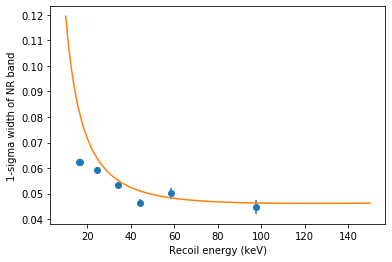

In [8]:


# get_sig_nuc_func_fit(FWHM_center, FWHM_guard, FWHM122_ion, FWHM0_heat, FWHM122_heat, V, aH=None, C = None)
#sig_nr_GGA3 = get_sig_nuc_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, V, aH)
sig_nr_func = get_sig_nuc_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, pars, aH=0.035, C=0.04)

plt.errorbar(E_recoil, sig_NR, yerr=sig_NR_err, fmt="o")

E_recoil_arr = np.linspace(10, 150, 100)
plt.plot(E_recoil_arr, sig_nr_func(E_recoil_arr))

plt.xlabel("Recoil energy (keV)")
plt.ylabel("1-sigma width of NR band")
#plt.ylim(0, 0.1)

params, params_cov = optimize.curve_fit(fit_func, E_recoil[2::], sig_NR[2::], sigma=sig_NR_err[2::], p0=[0.04])
#params, params_cov = optimize.curve_fit(fit_func, E_recoil, sig_NR, sigma=sig_NR_err, p0=[0.04])
perr = np.sqrt(np.diag(params_cov))
print(params, params_cov, perr, perr/params)

In [6]:
# How many counts are in the gaussian for 
# a particular energy bin?
# Here, GGA1 in bin 40 < ER < 60 keV
N = 125*3+80*2+55*2+25*3
print (N)

720


In [7]:
def std_error_mean(sig, N):
    return sig/np.sqrt(N)

def std_error_stdDev(sig, N):
    return sig/np.sqrt(2*(N-1))

In [17]:
# For the 40 < ER < 50 keV bin for GGA3 NR data,
# the mean is 0.047 and the error is reported as 0.0015
print (std_error_mean(0.047, 500))
print (std_error_stdDev(0.047, 500))

0.0021019038988498023
0.0014877590039073583
